## Project 1: Fidelity vs. Depth Mirror (©TB)

In [14]:
# fidelity_vs_depth_mirror.py
# -----------------------------------------------------------
# Sweep circuit depth and estimate fidelity via mirror circuits.
# Works on (A) Noisy Aer simulator (default) or (B) IBM hardware.
#
# Requirements:
#   pip install "qiskit[visualization]" qiskit-ibm-runtime qiskit-aer
# -----------------------------------------------------------

import math
import random
from dataclasses import dataclass
from typing import List
from pathlib import Path
import csv

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import transpile

# Hardware runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Noisy simulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

# -------------------- USER SETTINGS --------------------
N_QUBITS = 3
DEPTHS = [2, 4, 6, 8, 10, 12, 16, 20]
REPS_PER_DEPTH = 5
SHOTS = 4000

# Choose execution mode
USE_HARDWARE = False        # False -> Noisy Aer; True -> IBM hardware

# Hardware options (used only if USE_HARDWARE=True)
BACKEND_NAME = None         # e.g. "ibm_brisbane"; None -> least busy real device
OPT_LEVEL_HW = 3            # transpiler optimization level for hardware (0-3)

# Aer (noisy sim) options (used only if USE_HARDWARE=False)
P1Q = 0.005   # 0.5% 1Q depolarizing
P2Q = 0.03    # 3%   2Q depolarizing
PREAD = 0.02  # 2%   readout error
OPT_LEVEL_AER = 0           # keep 0 to avoid mirror cancellation
SEED_SIM = 1234             # reproducible sampling

# Output CSV
OUT_CSV = Path("fidelity_vs_depth.csv")
# -------------------------------------------------------

@dataclass
class TrialResult:
    backend_name: str
    raw_depth: int
    isa_depth: int
    depth: int
    rep: int
    shots: int
    p_success: float
    est_fidelity: float

def random_layer(qc: QuantumCircuit, rng: random.Random):
    """One 'layer': random single-qubit rotations + some entanglers."""
    n = qc.num_qubits
    for q in range(n):
        gate = rng.choice(["sx", "x", "h", "rx", "ry", "rz", "s", "t", "z", "y"])
        if gate == "sx":
            qc.sx(q)
        elif gate == "x":
            qc.x(q)
        elif gate == "h":
            qc.h(q)
        elif gate == "rx":
            qc.rx(2 * math.pi * rng.random(), q)
        elif gate == "ry":
            qc.ry(2 * math.pi * rng.random(), q)
        elif gate == "rz":
            qc.rz(2 * math.pi * rng.random(), q)
        elif gate == "s":
            qc.s(q)
        elif gate == "t":
            qc.t(q)
        elif gate == "z":
            qc.z(q)
        elif gate == "y":
            qc.y(q)

    if n > 1:
        candidates = [(i, j) for i in range(n) for j in range(n) if i < j]
        rng.shuffle(candidates)
        for (i, j) in candidates[: max(1, n // 2)]:
            qc.cx(i, j)

def make_mirror_circuit(n_qubits: int, depth: int, seed: int) -> QuantumCircuit:
    """Build random circuit of given depth, then append its inverse (with a barrier)."""
    rng = random.Random(seed)
    qreg = QuantumRegister(n_qubits, "q")
    creg = ClassicalRegister(n_qubits, "meas")
    qc = QuantumCircuit(qreg, creg, name="main")

    body = QuantumCircuit(n_qubits, name="Body")
    for _ in range(depth):
        random_layer(body, rng)

    qc.compose(body, inplace=True)
    qc.barrier()                         # prevents folding/cancellation
    qc.compose(body.inverse(), inplace=True)
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

def estimate_fidelity_from_success_prob(p_success: float, n_qubits: int) -> float:
    """
    Simple depolarizing-model estimator:
        F_est = (p_success - 1/2^n) / (1 - 1/2^n), clipped to [0,1].
    """
    floor = 1.0 / (2 ** n_qubits)
    if p_success <= floor:
        return 0.0
    return max(0.0, min(1.0, (p_success - floor) / (1 - floor)))

def build_aer_backend() -> AerSimulator:
    """Create a noisy AerSimulator with depolarizing + readout error."""
    noise = NoiseModel()
    # Add noise on transpiled basis gates typical for IBM devices:
    noise.add_all_qubit_quantum_error(depolarizing_error(P1Q, 1), ['sx', 'x', 'id'])
    noise.add_all_qubit_quantum_error(depolarizing_error(P2Q, 2), ['cx'])
    # Readout error
    ro = ReadoutError([[1 - PREAD, PREAD], [PREAD, 1 - PREAD]])
    noise.add_all_qubit_readout_error(ro)

    backend = AerSimulator(noise_model=noise, basis_gates=noise.basis_gates)
    backend.set_options(seed_simulator=SEED_SIM)
    return backend

def run_experiment() -> List[TrialResult]:
    results: List[TrialResult] = []

    if USE_HARDWARE:
        # ----- Hardware path (IBM Quantum) -----
        service = QiskitRuntimeService()
        backend = service.backend(BACKEND_NAME) if BACKEND_NAME else service.least_busy(
            operational=True, simulator=False
        )
        backend_name = backend.name
        print("Using hardware backend:", backend_name)

        pm = generate_preset_pass_manager(target=backend.target, optimization_level=OPT_LEVEL_HW)
        sampler = Sampler(mode=backend)
        sampler.options.default_shots = SHOTS

        for depth in DEPTHS:
            for rep in range(1, REPS_PER_DEPTH + 1):
                seed = 1000 * depth + rep
                qc = make_mirror_circuit(N_QUBITS, depth, seed)
                raw_depth = qc.depth()

                isa_qc = pm.run(qc)  # transpile to device
                isa_depth = isa_qc.depth()

                res = sampler.run([isa_qc]).result()
                counts = res[0].data.meas.get_counts()  # 'meas' register

                p0 = counts.get("0" * N_QUBITS, 0) / SHOTS
                f_est = estimate_fidelity_from_success_prob(p0, N_QUBITS)

                results.append(TrialResult(
                    backend_name=backend_name,
                    raw_depth=raw_depth,
                    isa_depth=isa_depth,
                    depth=depth,
                    rep=rep,
                    shots=SHOTS,
                    p_success=p0,
                    est_fidelity=f_est,
                ))
                print(f"depth={depth:>3} rep={rep}  raw={raw_depth:>4} isa={isa_depth:>4}  "
                      f"P0..0={p0:.6f}  F_est={f_est:.6f}")

    else:
        # ----- Noisy Aer path -----
        backend = build_aer_backend()
        backend_name = backend.name
        print("Using noisy Aer backend:", backend_name)
        print(f"Noise params: P1Q={P1Q}, P2Q={P2Q}, PREAD={PREAD}")

        for depth in DEPTHS:
            for rep in range(1, REPS_PER_DEPTH + 1):
                seed = 1000 * depth + rep
                qc = make_mirror_circuit(N_QUBITS, depth, seed)
                raw_depth = qc.depth()

                isa_qc = transpile(qc, backend=backend, optimization_level=OPT_LEVEL_AER)
                isa_depth = isa_qc.depth()

                job = backend.run(isa_qc, shots=SHOTS)
                result = job.result()
                counts = result.get_counts(isa_qc)

                p0 = counts.get("0" * N_QUBITS, 0) / SHOTS
                f_est = estimate_fidelity_from_success_prob(p0, N_QUBITS)

                results.append(TrialResult(
                    backend_name=backend_name,
                    raw_depth=raw_depth,
                    isa_depth=isa_depth,
                    depth=depth,
                    rep=rep,
                    shots=SHOTS,
                    p_success=p0,
                    est_fidelity=f_est,
                ))
                print(f"depth={depth:>3} rep={rep}  raw={raw_depth:>4} isa={isa_depth:>4}  "
                      f"P0..0={p0:.6f}  F_est={f_est:.6f}")

    return results

def save_csv(results: List[TrialResult], csv_path: Path):
    with csv_path.open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            "backend", "shots",
            "depth", "rep",
            "raw_depth", "isa_depth",
            "p_success", "fidelity_est",
            "p1q", "p2q", "pread"
        ])
        for r in results:
            w.writerow([
                r.backend_name, r.shots,
                r.depth, r.rep,
                r.raw_depth, r.isa_depth,
                f"{r.p_success:.6f}", f"{r.est_fidelity:.6f}",
                f"{P1Q:.6f}", f"{P2Q:.6f}", f"{PREAD:.6f}"
            ])
    print(f"\nSaved: {csv_path.resolve()}")

def summarize(results: List[TrialResult]):
    from statistics import mean, stdev
    by_depth = {}
    for r in results:
        by_depth.setdefault(r.depth, []).append(r)

    print("\n=== Aggregated by depth ===")
    print("depth, mean_p_success, sd_p_success, mean_F_est, sd_F_est, mean_isa_depth")
    for d in sorted(by_depth):
        ps = [x.p_success for x in by_depth[d]]
        fs = [x.est_fidelity for x in by_depth[d]]
        ids = [x.isa_depth for x in by_depth[d]]
        mps = mean(ps)
        mfs = mean(fs)
        mids = mean(ids)
        sps = (stdev(ps) if len(ps) > 1 else 0.0)
        sfs = (stdev(fs) if len(fs) > 1 else 0.0)
        print(f"{d}, {mps:.6f}, {sps:.6f}, {mfs:.6f}, {sfs:.6f}, {mids:.2f}")

if __name__ == "__main__":
    results = run_experiment()
    save_csv(results, OUT_CSV)
    summarize(results)
    print("\nTip: plot mean fidelity vs. ISA depth (post-transpile) for the most physical picture.")


Using noisy Aer backend: aer_simulator
Noise params: P1Q=0.005, P2Q=0.03, PREAD=0.02
depth=  2 rep=1  raw=   9 isa=  16  P0..0=0.841250  F_est=0.818571
depth=  2 rep=2  raw=   9 isa=  20  P0..0=0.828750  F_est=0.804286
depth=  2 rep=3  raw=   9 isa=  13  P0..0=0.841750  F_est=0.819143
depth=  2 rep=4  raw=   9 isa=  14  P0..0=0.837000  F_est=0.813714
depth=  2 rep=5  raw=   9 isa=  13  P0..0=0.846750  F_est=0.824857
depth=  4 rep=1  raw=  17 isa=  25  P0..0=0.772000  F_est=0.739429
depth=  4 rep=2  raw=  17 isa=  31  P0..0=0.759750  F_est=0.725429
depth=  4 rep=3  raw=  17 isa=  35  P0..0=0.740250  F_est=0.703143
depth=  4 rep=4  raw=  17 isa=  37  P0..0=0.748250  F_est=0.712286
depth=  4 rep=5  raw=  17 isa=  29  P0..0=0.757750  F_est=0.723143
depth=  6 rep=1  raw=  25 isa=  45  P0..0=0.669500  F_est=0.622286
depth=  6 rep=2  raw=  25 isa=  51  P0..0=0.681000  F_est=0.635429
depth=  6 rep=3  raw=  25 isa=  52  P0..0=0.658250  F_est=0.609429
depth=  6 rep=4  raw=  25 isa=  51  P0..0=0.

In [15]:
import pandas as pd
from pathlib import Path

# Load the CSV you saved from the experiment script
csv_path = Path("fidelity_vs_depth.csv")
df = pd.read_csv(csv_path)

# Peek
display(df.head())

# Aggregate by depth
agg = (
    df.groupby("depth")
      .agg(mean_fid=("fidelity_est", "mean"),
           sd_fid=("fidelity_est", "std"),
           n=("fidelity_est", "size"))
      .reset_index()
)

# If only 1 rep at a depth, std is NaN -> set to 0
agg["sd_fid"] = agg["sd_fid"].fillna(0.0)

# 95% CI (optional; uses normal approx)
import numpy as np
agg["sem"] = agg["sd_fid"] / np.sqrt(agg["n"].clip(lower=1))
agg["ci95"] = 1.96 * agg["sem"]

display(agg)


,backend,shots,depth,rep,raw_depth,isa_depth,p_success,fidelity_est,p1q,p2q,pread
0,aer_simulator,4000,2,1,9,16,0.84125,0.818571,0.005,0.03,0.02
1,aer_simulator,4000,2,2,9,20,0.82875,0.804286,0.005,0.03,0.02
2,aer_simulator,4000,2,3,9,13,0.84175,0.819143,0.005,0.03,0.02
3,aer_simulator,4000,2,4,9,14,0.83700,0.813714,0.005,0.03,0.02
4,aer_simulator,4000,2,5,9,13,0.84675,0.824857,0.005,0.03,0.02


,depth,mean_fid,sd_fid,n,sem,ci95
0,2,0.816114,0.007702,5,0.003445,0.006752
1,4,0.720686,0.013767,5,0.006157,0.012068
2,6,0.622857,0.013016,5,0.005821,0.011409
3,8,0.527486,0.007934,5,0.003548,0.006955
4,10,0.453943,0.023144,5,0.010350,0.020287
5,12,0.392286,0.005918,5,0.002646,0.005187
6,16,0.292857,0.003586,5,0.001604,0.003143
7,20,0.201943,0.012716,5,0.005687,0.011146


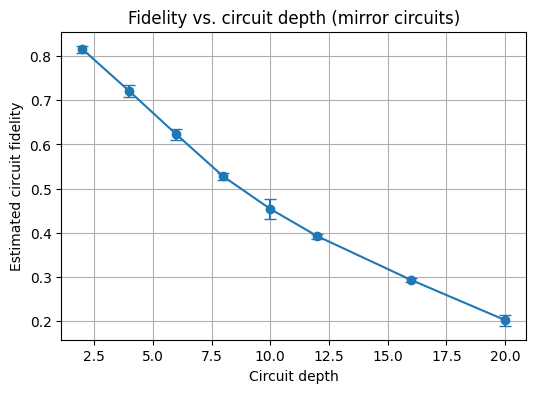

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.errorbar(
    agg["depth"], agg["mean_fid"],
    yerr=agg["sd_fid"], fmt="o-", capsize=4
)
plt.xlabel("Circuit depth")
plt.ylabel("Estimated circuit fidelity")
plt.title("Fidelity vs. circuit depth (mirror circuits)")
plt.grid(True)
plt.show()
